# 你怎麼判斷紅酒的品質，靠味蕾還是機器學習？

- https://reurl.cc/g7y7Ab

In [ ]:
!pip3 install --upgrade yellowbrick

# 載入常用程式庫及定義

In [1]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '\\Google Drive\\adventures\\'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
# import gdown
import requests
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

data_dir = groot_dir + 'wine quality\\'
figure_dir = groot_dir + 'wine quality\\'


gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath
        
def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0  
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]   
    return s

TAIWAN_CSV = '1I5yqulrZSHPSQkxT3oqt_3uVAhPolOEP'
RED_WINE = '1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk'
TITANIC_TRAIN = '1PrxmUKRQWSlYgtMU13l1E0ob4hVJI20O'
JHU_CSSE = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
MNIST_TRAIN = '1E-uJ0zqqAfpsVjoOSzqF5TXhDfPNlkQ5'
MNIST_TRAIN_LABEL = '13clNJ2cd2I90W3DEkDBKjZSDNNEqqx3B'
MNIST_TEST = '1zVpVHJl5YABa3qExt1K-O3WaEHXTJekg'
MNIST_TEST_LABEL = '1qci_-dqubnRN-cdrCsbYaUAxyO7_jH9z'

print('\nThis module is amied to explore wine quality csv...')

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage root points to ==>', groot_dir)
print('Wine Quality data will be stored at ==>', data_dir)
print('\nLibraries and dependenciess imported')
print_local_now()


This module is amied to explore wine quality csv...

Running on win32
Python Version 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Data storage root points to ==> C:\Users\TyKA\Google Drive\adventures\
Wine Quality data will be stored at ==> C:\Users\TyKA\Google Drive\adventures\wine quality\

Libraries and dependenciess imported
Local Time: 2021-03-06 12:49:41.765290


# 熱身：sklearn load_wine

- [sklearn datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)
- [UCI Archive](https://archive.ics.uci.edu/ml/datasets/Wine)

load_xxxx() 傳回的資料是一種叫 bunch 的資料結構，裏面幾個主要欄位的意義是：

- 'features_names': 特徵名，也就是 X 各欄位的名字
- 'target_names': y 的欄位名稱
- ‘data‘： 資料的內容，也就是 X 的所有數值
- ’target‘：標籤，也就是 y 的數值


In [2]:
from sklearn.datasets import load_wine

wdata = load_wine()

In [3]:
for key, value in wdata.items():
    try:
        print(key, value.shape, type(value))
    except:
        print(key, type(value))

print("-"*6)
print(wdata["feature_names"])
print(wdata["target_names"])

data (178, 13) <class 'numpy.ndarray'>
target (178,) <class 'numpy.ndarray'>
frame <class 'NoneType'>
target_names (3,) <class 'numpy.ndarray'>
DESCR <class 'str'>
feature_names <class 'list'>
------
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


In [4]:
X1, y1 = load_wine(return_X_y=True)

In [5]:
X1.shape, wdata["data"].shape

((178, 13), (178, 13))

In [6]:
wdf = pd.DataFrame(data = wdata["data"], columns=wdata["feature_names"])
wdf["target"] = wdata["target"]

In [7]:
wdf.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [8]:
wdf.shape

(178, 14)

### 各欄位的定義

- malic acid 蘋果酸
- ash acid 灰
- alcalinity of ash 灰的鹼性
- magnesium 鎂
- total phenols 總酚
- nonflavanoid_phenols 非類黃酮
- proanthocyanins 原花青素
- color intensity 顏色強度
- hue 色調
- proline 脯氨酸

### 欄位間的關聯

<ipython-input-9-596a57d99747>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  wdf.hist(ax = ax)


array([[<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'malic_acid'}>,
        <AxesSubplot:title={'center':'ash'}>,
        <AxesSubplot:title={'center':'alcalinity_of_ash'}>],
       [<AxesSubplot:title={'center':'magnesium'}>,
        <AxesSubplot:title={'center':'total_phenols'}>,
        <AxesSubplot:title={'center':'flavanoids'}>,
        <AxesSubplot:title={'center':'nonflavanoid_phenols'}>],
       [<AxesSubplot:title={'center':'proanthocyanins'}>,
        <AxesSubplot:title={'center':'color_intensity'}>,
        <AxesSubplot:title={'center':'hue'}>,
        <AxesSubplot:title={'center':'od280/od315_of_diluted_wines'}>],
       [<AxesSubplot:title={'center':'proline'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

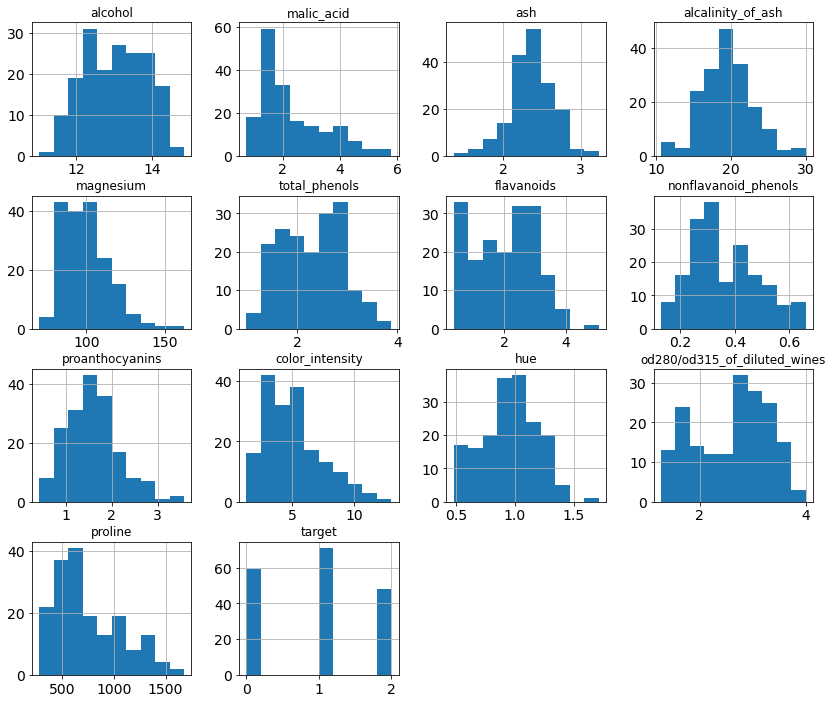

In [9]:
fig, ax  = plt.subplots(figsize = (14, 12))
wdf.hist(ax = ax)

In [10]:
corr = wdf.corr()
type(corr)

pandas.core.frame.DataFrame

In [11]:
corr

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115,-0.719163
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193,-0.847498
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100,0.265668


<AxesSubplot:>

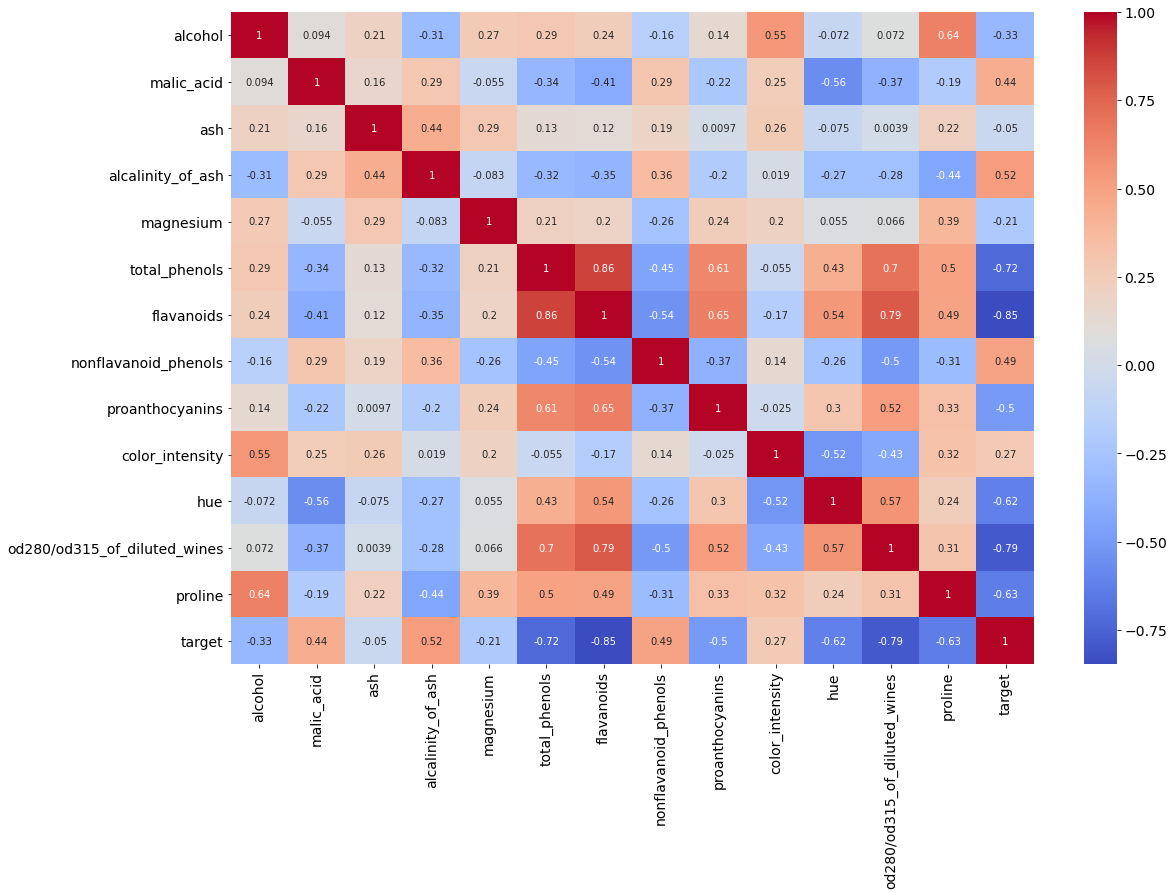

In [12]:
plt.subplots(figsize = (18, 12))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.index, annot=True, cmap = "coolwarm")

<AxesSubplot:xlabel='target', ylabel='count'>

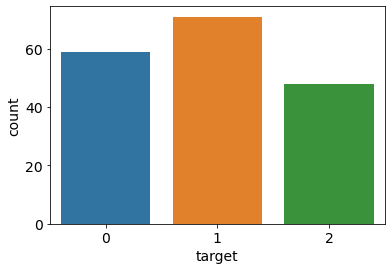

In [13]:
sns.countplot(x = "target", data = wdf)

In [14]:
wdf["target"].unique()

array([0, 1, 2])

In [15]:
wdf.target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

In [16]:
wdf.target.dtypes

dtype('int32')

In [17]:
wdf.alcalinity_of_ash.dtypes

dtype('float64')

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='Density'>

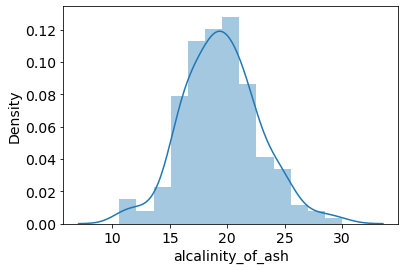

In [18]:
sns.distplot(wdf.alcalinity_of_ash, kde = 1)

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alcohol', ylabel='Density'>

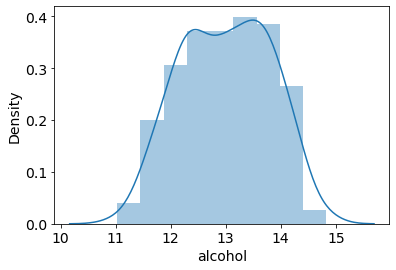

In [19]:
sns.distplot(wdf.alcohol, kde = 1)

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='target'>

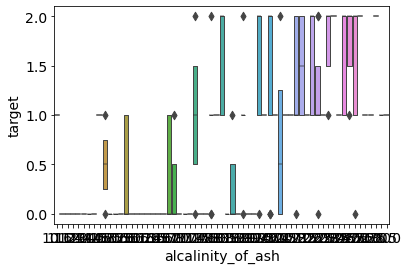

In [20]:
sns.boxenplot(x = wdf.alcalinity_of_ash, y = wdf.target)

In [21]:
wdf["class"] = wdf["target"].map({0: "class 0", 1: "class 1", 2: "class 2"})

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='class'>

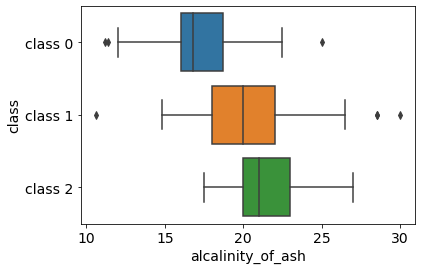

In [22]:
sns.boxplot(x = wdf.alcalinity_of_ash, y = wdf["class"])

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='class'>

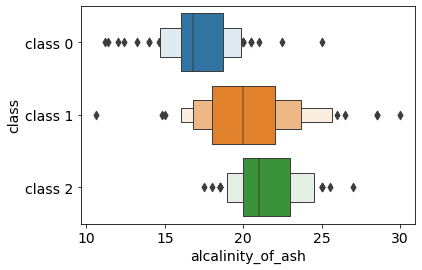

In [23]:
sns.boxenplot(x = wdf.alcalinity_of_ash, y = wdf["class"])

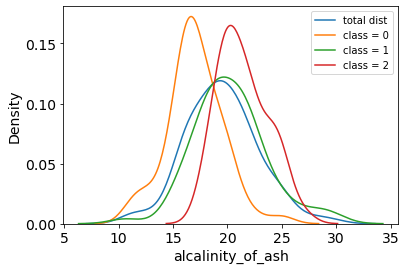

In [24]:
sns.kdeplot(x = wdf.alcalinity_of_ash, label = "total dist")
sns.kdeplot(x = wdf.alcalinity_of_ash[wdf.target == 0], label = "class = 0")
sns.kdeplot(x = wdf.alcalinity_of_ash[wdf.target == 1], label = "class = 1")
sns.kdeplot(x = wdf.alcalinity_of_ash[wdf.target == 2], label = "class = 2")
plt.legend(loc = "best")

# 第二個資料檔 Wine Quality

- [UCI: Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- [Predicting Wine Quality with Several Classification Techniques](https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434)
- [Wine Quality CSV (kaggle version)](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
- [Step-by-step guide for predicting Wine Preferences using Scikit-Learn](https://medium.com/analytics-vidhya/step-by-step-guide-for-predicting-wine-quality-using-scikit-learn-de5869f8f91a)

## 下載 wine quality data

### from UCI repository

In [25]:
wine_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

In [26]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [27]:
fetch_file_via_requests(wine_url, data_dir)
wind_dfile = os.path.join(data_dir, "winequality-red.csv")

### from shared google drive

https://drive.google.com/uc?id=1ZDg4EfKkkjsWXfs4L3DkZhnAIfnq98Vk

- [Pandas DataFrame.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [28]:
wine_dbfile = os.path.join(data_dir, 'winequality-red.csv')
df = pd.read_csv(wine_dbfile, sep=';')

In [29]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [30]:
# 確認有無 NA
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

- fixed acidity 固定酸度
- volatile acidity 揮發性酸度
- citric acid 檸檬酸
- residual sugar 殘糖
- chlorides 氯化物
- free sulfur dioxide 游離二氧化硫
- total sulfur dioxide 總二氧化硫
- sulphates 硫酸鹽
- alcohol 酒精
- pH 酸鹼值
- density 密度

## Explore Dataset

In [31]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [33]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [34]:
df.shape

(1599, 12)

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

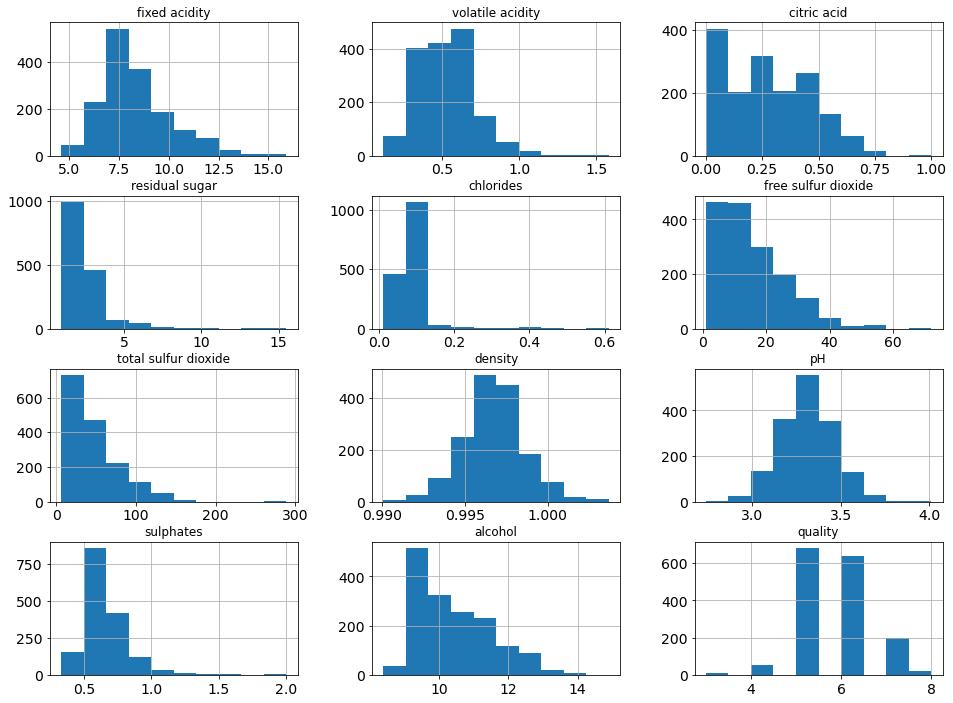

In [35]:
df.hist(bins = 10, figsize = (16, 12))

<AxesSubplot:>

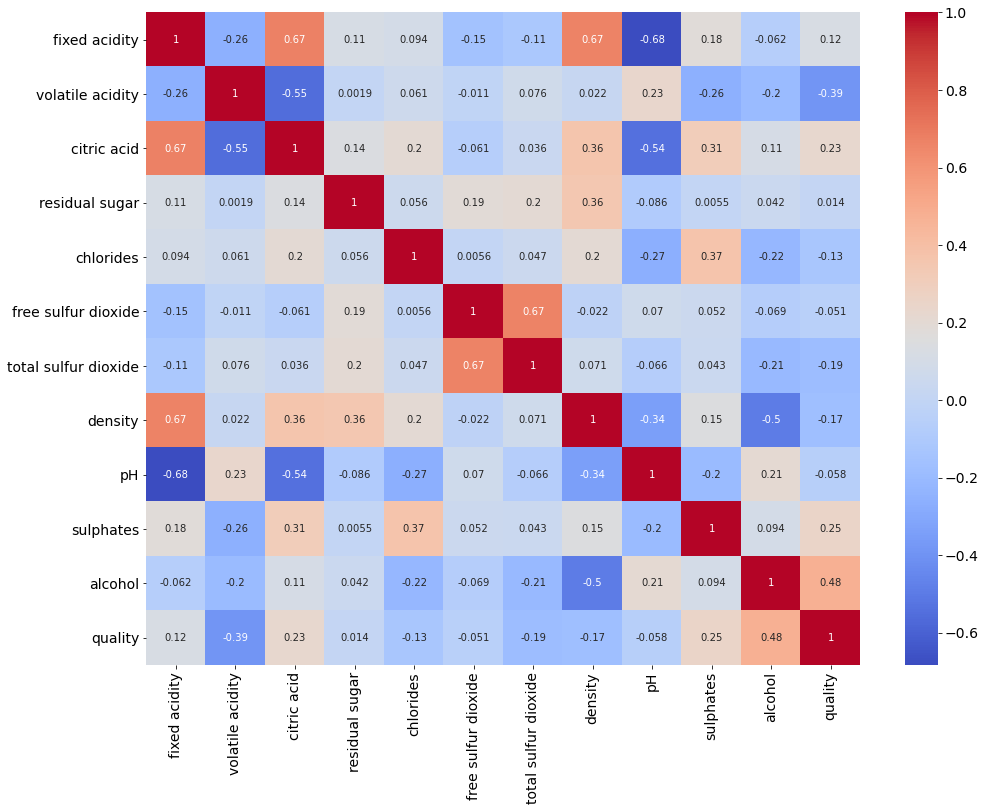

In [36]:
fig, ax = plt.subplots(figsize=(16, 12))
corr = df.corr()
sns.heatmap(corr, xticklabels = df.columns, yticklabels=df.columns, cmap = "coolwarm", annot=True, ax = ax)

### DataFrame Overview 整體資訊

### 特定欄位的相關資訊

In [37]:
df.alcohol.mean()

10.422983114446502

In [38]:
df.alcohol.value_counts()

9.500000     139
9.400000     103
9.800000      78
9.200000      72
10.500000     67
            ... 
11.950000      1
9.233333       1
11.066667      1
13.200000      1
9.566667       1
Name: alcohol, Length: 65, dtype: int64

In [39]:
len(df.alcohol.unique())

65

<AxesSubplot:xlabel='alcohol'>

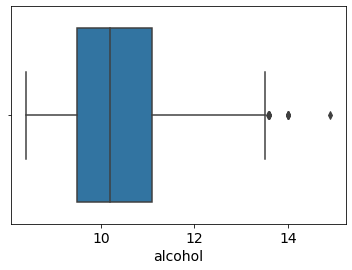

In [40]:
sns.boxplot(x = df.alcohol)

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='alcohol', ylabel='Density'>

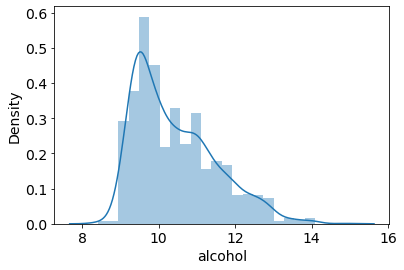

In [41]:
sns.distplot(df.alcohol)

In [42]:
df["quality"].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quality', ylabel='count'>

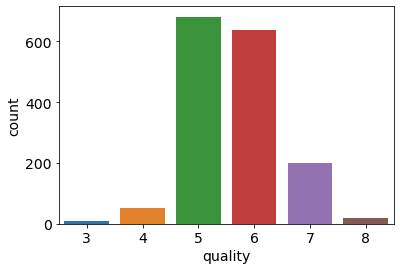

In [43]:
sns.countplot(df.quality)

In [44]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [45]:
df.loc[df["quality"] == 3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
459,11.6,0.580,0.66,2.20,0.074,10.0,47.0,1.00080,3.25,0.57,9.00,3
517,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3
690,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.70,3
832,10.4,0.440,0.42,1.50,0.145,34.0,48.0,0.99832,3.38,0.86,9.90,3
899,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.00,3
1299,7.6,1.580,0.00,2.10,0.137,5.0,9.0,0.99476,3.50,0.40,10.90,3
1374,6.8,0.815,0.00,1.20,0.267,16.0,29.0,0.99471,3.32,0.51,9.80,3
1469,7.3,0.980,0.05,2.10,0.061,20.0,49.0,0.99705,3.31,0.55,9.70,3
1478,7.1,0.875,0.05,5.70,0.082,3.0,14.0,0.99808,3.40,0.52,10.20,3
1505,6.7,0.760,0.02,1.80,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3


In [46]:
type(df.loc[df["quality"] == 3])

pandas.core.frame.DataFrame

In [47]:
dfqu8 = df.loc[df["quality"] == 8]
dfqu8.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444,8.0
std,2.119656,0.144914,0.199526,1.295038,0.011678,11.155613,25.433240,0.002378,0.200640,0.115379,1.224011,0.0
min,5.000000,0.260000,0.030000,1.400000,0.044000,3.000000,12.000000,0.990800,2.880000,0.630000,9.800000,8.0
25%,7.250000,0.335000,0.302500,1.800000,0.062000,6.000000,16.000000,0.994175,3.162500,0.690000,11.325000,8.0
50%,8.250000,0.370000,0.420000,2.100000,0.070500,7.500000,21.500000,0.994940,3.230000,0.740000,12.150000,8.0
75%,10.225000,0.472500,0.530000,2.600000,0.075500,16.500000,43.000000,0.997200,3.350000,0.820000,12.875000,8.0
max,12.600000,0.850000,0.720000,6.400000,0.086000,42.000000,88.000000,0.998800,3.720000,1.100000,14.000000,8.0


In [48]:
corr = df.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [49]:
corr.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [50]:
corr["quality"].sort_values(ascending = False)[1:]

alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

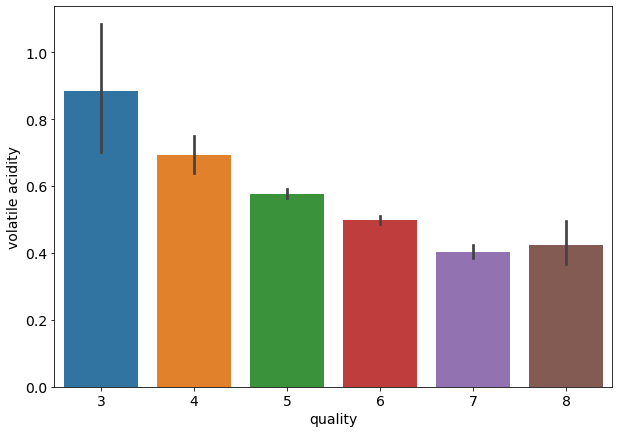

In [51]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.barplot(x = df.quality, y = df["volatile acidity"])

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

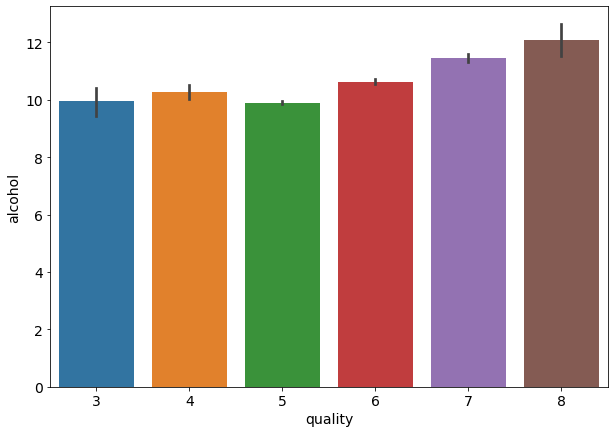

In [52]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.barplot(x = df.quality, y = df["alcohol"])

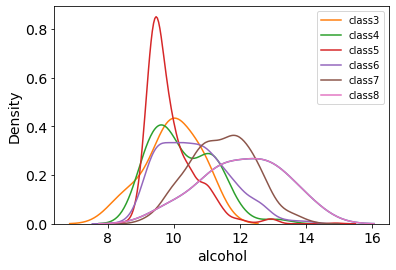

In [53]:
sns.kdeplot(df.alcohol[df["quality"] == 8])

for i in np.sort(df.quality.unique()):
    sns.kdeplot(df.alcohol[df["quality"] == i], \
               label = f"class{i:d}")
plt.legend(loc = "best")

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


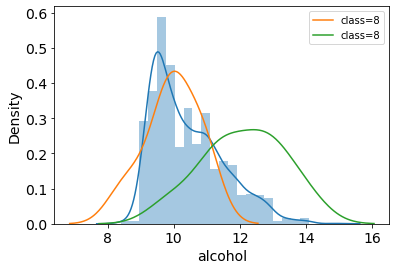

In [54]:
sns.distplot(df.alcohol)
sns.kdeplot(df.alcohol[df["quality"] == 3], label = f"class={i:d}")
sns.kdeplot(df.alcohol[df["quality"] == 8], label = f"class={i:d}")
plt.legend(loc = "best")

### 兩個欄位之間的關係

## Binay Classification

In [55]:
y6 = df.quality > 6

C:\Users\TyKA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quality', ylabel='count'>

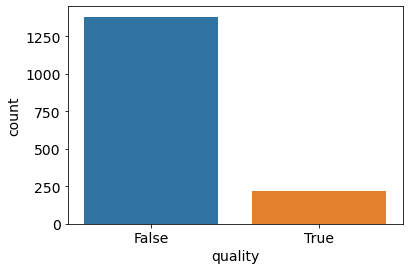

In [56]:
sns.countplot(y6)

In [57]:
bins = (2, 6.5, 8)
group_name = ["bad", "good"]
df.quality = pd.cut(
    df.quality, bins= bins, labels = group_name
)

In [58]:
df.quality

0       bad
1       bad
2       bad
3       bad
4       bad
       ... 
1594    bad
1595    bad
1596    bad
1597    bad
1598    bad
Name: quality, Length: 1599, dtype: category
Categories (2, object): ['bad' < 'good']

In [57]:
df.quality.value_counts()

bad     1382
good     217
Name: quality, dtype: int64

### Select Classifier

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [60]:
%%time
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Wall time: 0 ns


In [61]:
X = df.drop(["quality"], axis = 1)
y = y6
# y = df["quality"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [62]:
sc = MinMaxScaler()
# sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

clf = LinearSVC()
clf.fit(x_train, y_train)
y_hat = clf.predict(x_test)
rep = classification_report(y_test, y_hat)
print(rep)
print_now()

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       347
        True       0.48      0.55      0.51        53

    accuracy                           0.86       400
   macro avg       0.71      0.73      0.72       400
weighted avg       0.87      0.86      0.87       400

2021-03-06 12:50:43.268400


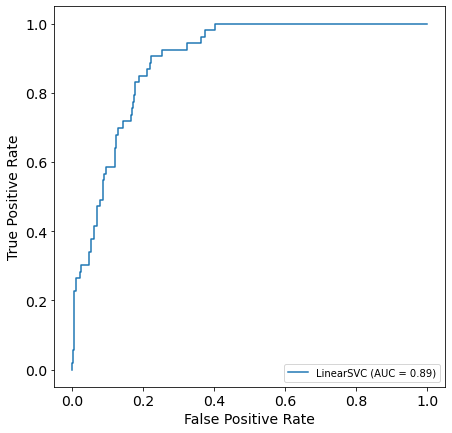

In [63]:
fig, ax  = plt.subplots(figsize=(7, 7))
plot_roc_curve(clf, x_test, y_test, ax = ax)

## Comparison of Algorithms

- [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [66]:
models = []
models.append(('LinearSVC', LinearSVC()))
models.append(('StochasticGD', SGDClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNeighbors', KNeighborsClassifier()))
# models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('LR Classifier', LogisticRegression()))
from sklearn.model_selection import KFold

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = df.drop(["quality"], axis=1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

results = []
names = []
scores = []
seed = 7
scoring = "accuracy"

for name, model in models:
    kfold = KFold(n_splits=10, random_state= seed)
    cv_results = cross_val_score(model, x_train, y_train, cv = kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name:s} done, {cv_results.mean():f}")

print_now()

C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarnin

LinearSVC done, 0.881625
StochasticGD done, 0.853207
RandomForest done, 0.907472
DecisionTree done, 0.879097
GaussianNB done, 0.834846
KNeighbors done, 0.868263

C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(



LR Classifier done, 0.877451
2021-03-06 13:02:36.380886


C:\Users\TyKA\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [70]:
for i, r in enumerate(results):
    print(models[i][0])
    print("mean = %.4f, std = %.4f" % (r.mean(), r.std()))

LinearSVC
mean = 0.8816, std = 0.0340
StochasticGD
mean = 0.8532, std = 0.0155
RandomForest
mean = 0.9075, std = 0.0350
DecisionTree
mean = 0.8791, std = 0.0327
GaussianNB
mean = 0.8348, std = 0.0191
KNeighbors
mean = 0.8683, std = 0.0319
LR Classifier
mean = 0.8775, std = 0.0322


Text(0.5, 1.0, 'Algorithm Comparison')

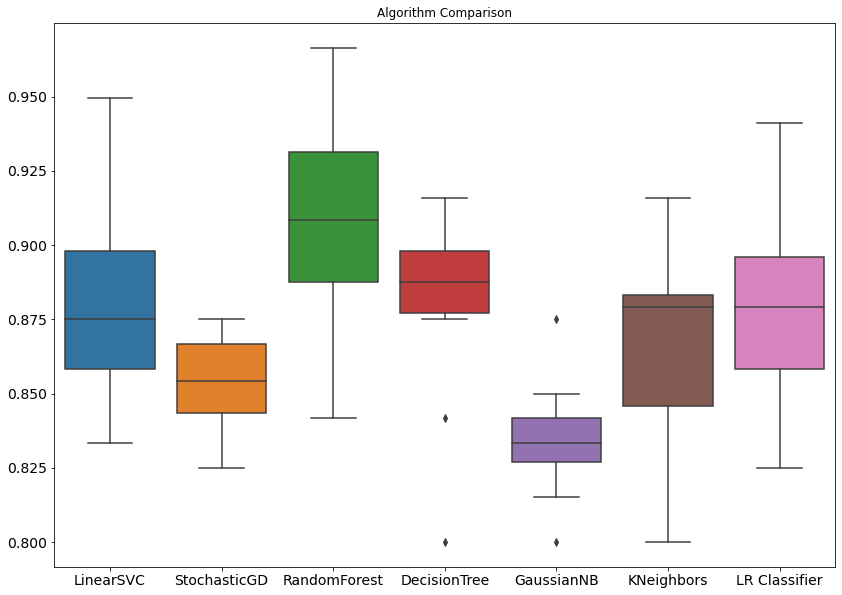

In [71]:
adf = pd.DataFrame(data = results).transpose()
adf.columns = names

fig, ax = plt.subplots(figsize = (14, 10))
sns.boxplot(data=adf, ax=ax)
plt.title("Algorithm Comparison")

## Tuning Hyperparameters

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
- [kNN API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier)

In [72]:
X = df.drop(["quality"], axis = 1)
y = y6

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42
)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def knn_param_selection(X, y, nfolds):
    param = {
        "n_neighbors": [1, 3, 5, 7, 9],
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    }
    grid_search = GridSearchCV(KNeighborsClassifier(),
                              param_grid=param, 
                              scoring="accuracy",
                              cv = nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_
print(knn_param_selection(x_train, y_train, nfolds=5))

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'weights': 'distance'}


- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC)